General imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import seaborn as sns
from joblib import Parallel, delayed
from multiprocessing import cpu_count

from statsmodels.tsa.statespace.sarimax import SARIMAX

Reading dataset

In [3]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

Quick view to the data

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Cleaning data

In [6]:
from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

df.dropna()
df = clean(df, method = "replaceval",       
                columns = [],     # [] to replace in all columns
                to_replace = "",  # value to be replaced
                value = np.nan)   # value to replaced with
df = clean(df, method = "fillmissing")  # It uses the interpolation method
df = clean(df, method = "dropmissing")
explore(df)

ModuleNotFoundError: No module named 'quickda'

Meses (de todos los años) vs. Temperatura promedio en esos meses

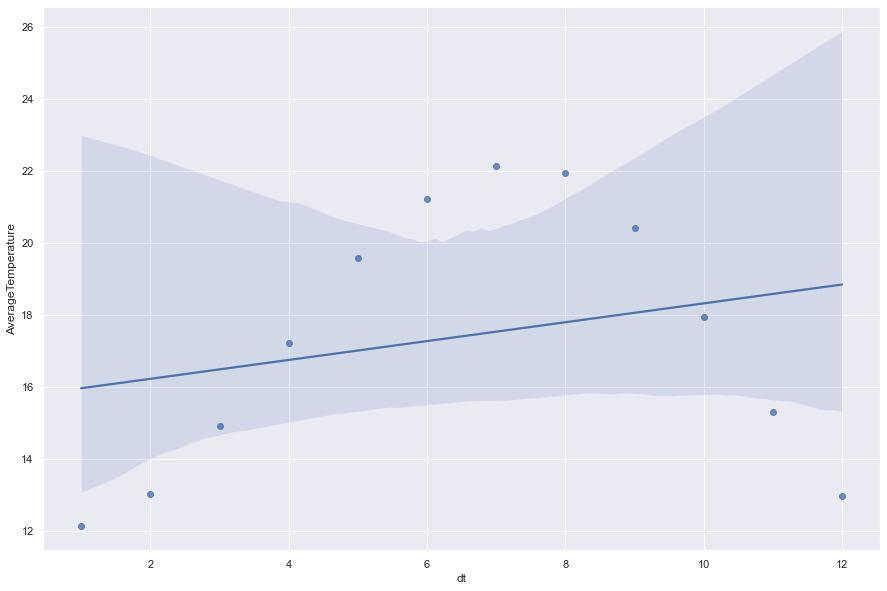

In [ ]:
df['dt'] = pd.to_datetime(df['dt'])
monthlyDF = df.groupby(df['dt'].dt.strftime('%m'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature')
# monthlyDF
monthlyDF = monthlyDF.sort_values('dt')
monthlyDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
monthlyDF['AverageTemperature'] = monthlyDF['AverageTemperature'].apply(lambda x: float(x))
monthlyDF['dt'] = monthlyDF['dt'].apply(lambda x: float(x))
sns.regplot(x=monthlyDF["dt"], y=monthlyDF["AverageTemperature"])
plt.show()

#### Comportamiento de la temperatura promedio en los últimos 20 años

Obteniendo temperatura de los últimos años (desde 1900)

In [ ]:
lastYearsDF = df[(df['dt'] > '1900-01-01')]
lastYearsDF = (lastYearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
lastYearsDF = lastYearsDF.sort_values('dt')
lastYearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
lastYearsDF['AverageTemperature'] = lastYearsDF['AverageTemperature'].apply(lambda x: float(x))
lastYearsDF['dt'] = lastYearsDF['dt'].apply(lambda x: float(x))
lastYearsDF['type'] = 'lastYears'
lastYearsDF.head()

,dt,AverageTemperature,type
87,1900.0,19.035455,lastYears
19,1901.0,18.532834,lastYears
5,1902.0,18.339032,lastYears
11,1903.0,18.434771,lastYears
1,1904.0,18.211075,lastYears


Obteniendo temperatura de los últimos años (desde 1995)

In [ ]:
last20YearsDF = df[(df['dt'] > '1995-09-01') & (df['dt'] < '2013-09-01')]
last20YearsDF = (last20YearsDF.groupby(df['dt'].dt.strftime('%Y'))['AverageTemperature'].mean().sort_values().reset_index(name='AverageTemperature'))
last20YearsDF = last20YearsDF.sort_values('dt')
last20YearsDF.rename(columns={0 : 'AverageTemperature'}, inplace=True)
last20YearsDF['AverageTemperature'] = last20YearsDF['AverageTemperature'].apply(lambda x: float(x))
last20YearsDF['dt'] = last20YearsDF['dt'].apply(lambda x: float(x))
last20YearsDF['type'] = 'last20Years'
last20YearsDF.head()

,dt,AverageTemperature,type
0,1995.0,17.413683,last20Years
1,1996.0,19.000665,last20Years
2,1997.0,19.291440,last20Years
15,1998.0,19.636447,last20Years
4,1999.0,19.432605,last20Years


Juntando ambos subdatasets

In [ ]:
lastYearsDF = pd.concat([lastYearsDF, last20YearsDF], ignore_index=True)
lastYearsDF.head()

,dt,AverageTemperature,type
0,1900.0,19.035455,lastYears
1,1901.0,18.532834,lastYears
2,1902.0,18.339032,lastYears
3,1903.0,18.434771,lastYears
4,1904.0,18.211075,lastYears


Graficando subdatasets

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

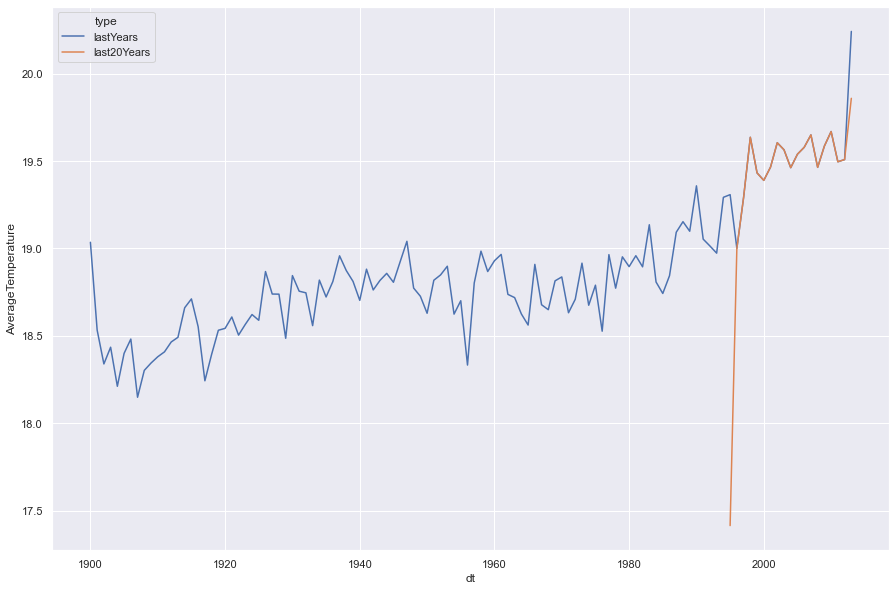

In [ ]:
sns.lineplot(x=lastYearsDF["dt"], y=lastYearsDF["AverageTemperature"], hue=lastYearsDF["type"], markers=True)

Graficando solo subdataset de temperatura promedio en los últimos 20 años

<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

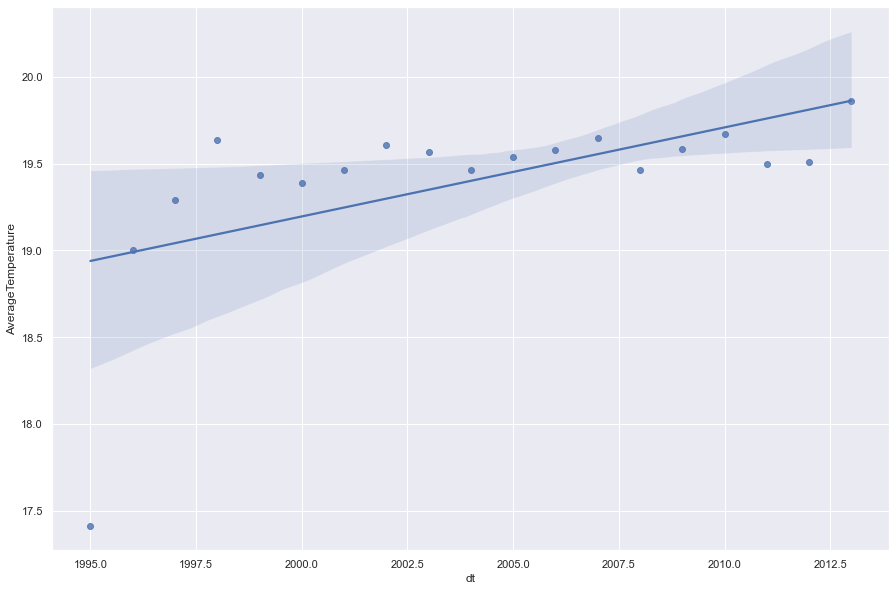

In [ ]:
sns.regplot(x=last20YearsDF["dt"], y=last20YearsDF["AverageTemperature"], label='last20Years')

Histograma de la temperatura promedio (Vista en el reporte)

<AxesSubplot:>

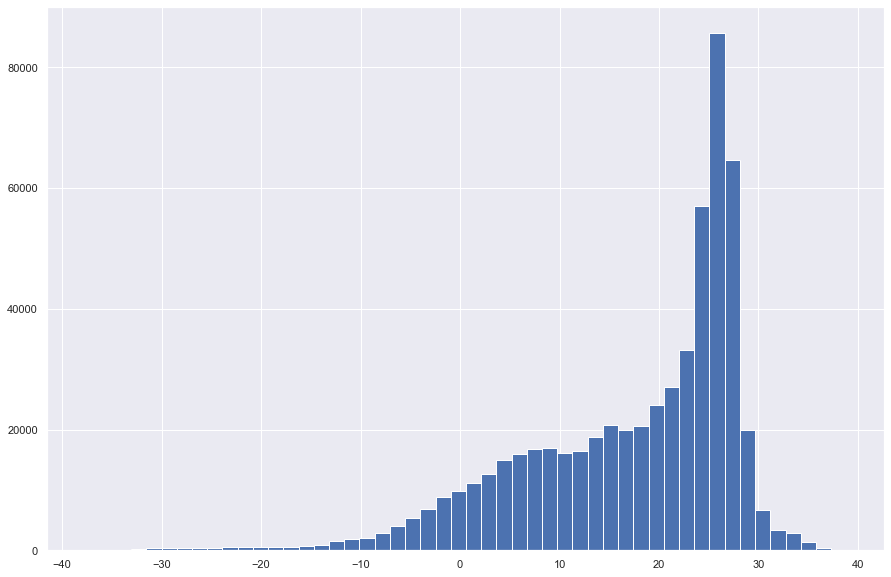

In [ ]:
#2a.

df['AverageTemperature'].hist(bins=50)

Descomposición de la serie en sus componentes (Tendencia, estacional y aleatoria)

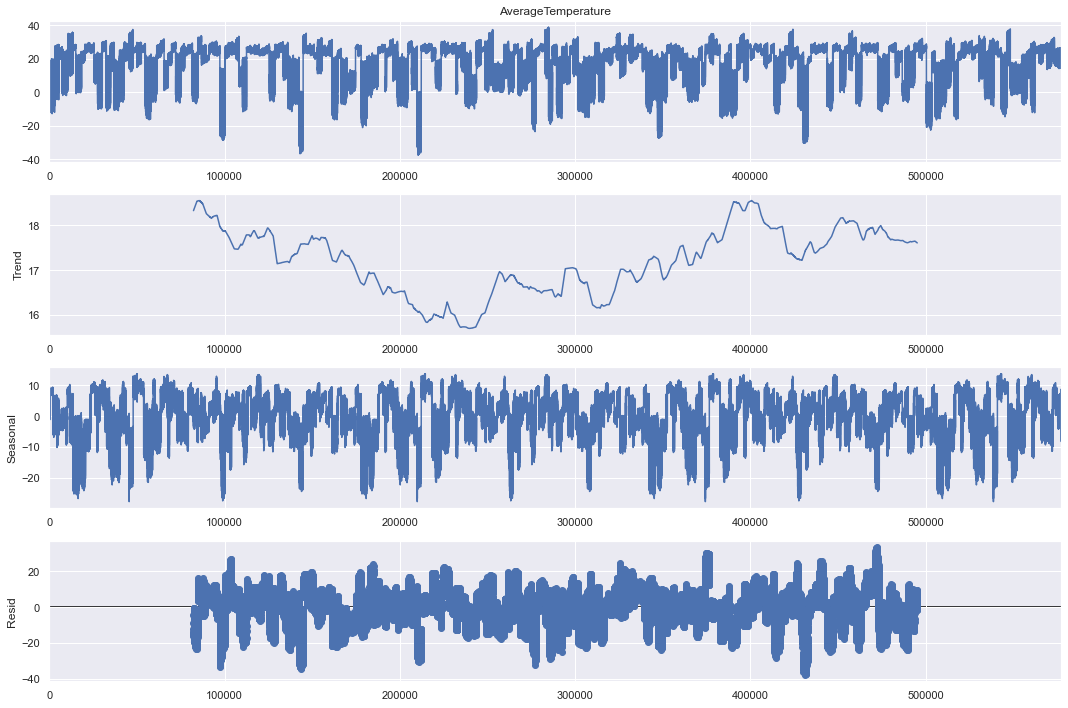

In [ ]:
#2c

rcParams['figure.figsize'] = 15, 10

decomposition = sm.tsa.seasonal_decompose(df['AverageTemperature'],model='additive', period=164409)

fig = decomposition.plot()
plt.show()

Transformación de la serie

In [ ]:
#2d 

# No es neecsario por la calidad de los datos

Modelo SARIMA

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

df_selected = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates = ["dt"], index_col=0)
df_selected = df_selected.dropna()
df_selected = df_selected.loc['2000-01-01':]
df_selected = df_selected.groupby(['dt']).mean()

df_selected = df_selected.drop(['AverageTemperatureUncertainty'], axis=1)
df_selected

p = [0, 1, 2]
d = [0, 1]
q = [0, 1, 2]

for p_ in p:
    for d_ in d:
        for q_ in q:
            train = df_selected.iloc[:len(df_selected)-12]
            test = df_selected.iloc[len(df_selected)-12:]

            model = SARIMAX(train['AverageTemperature'], 
                            order = (p_, d_, q_),
                            seasonal_order =(2, 1, 1, 12))

            result = model.fit()
            print(result.summary())

            print('\n')


c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:         AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, [1], 12)   Log Likelihood                 -24.569
Date:                    Mon, 08 Aug 2022   AIC                             57.138
Time:                            13:27:33   BIC                             68.933
Sample:                        01-01-2000   HQIC                            61.931
                             - 09-01-2012                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2542      0.162     -1.565      0.118      -0.573       0.064
ar.S.L24      -0.1970      0.119     -1.655      0.098      -0.430       0.036
ma.S.L12      -0.777

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -20.664
Date:                            Mon, 08 Aug 2022   AIC                             51.328
Time:                                    13:27:33   BIC                             66.071
Sample:                                01-01-2000   HQIC                            57.319
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2219      0.089      2.480      0.013       0.047       0.397
ar.S.L12      -0.1691      0.165   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -19.498
Date:                              Mon, 08 Aug 2022   AIC                             50.996
Time:                                      13:27:34   BIC                             68.688
Sample:                                  01-01-2000   HQIC                            58.185
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2188      0.097      2.263      0.024       0.029       0.408
ma.L2          0.12

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -49.581
Date:                              Mon, 08 Aug 2022   AIC                            107.161
Time:                                      13:27:35   BIC                            118.928
Sample:                                  01-01-2000   HQIC                           111.943
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0478      0.173     -0.276      0.783      -0.387       0.292
ar.S.L24       0.05

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -24.453
Date:                            Mon, 08 Aug 2022   AIC                             58.906
Time:                                    13:27:36   BIC                             73.615
Sample:                                01-01-2000   HQIC                            64.883
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7099      0.073     -9.717      0.000      -0.853      -0.567
ar.S.L12      -0.1341      0.195   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -24.023
Date:                              Mon, 08 Aug 2022   AIC                             60.046
Time:                                      13:27:37   BIC                             77.696
Sample:                                  01-01-2000   HQIC                            67.218
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6926      0.096     -7.187      0.000      -0.881      -0.504
ma.L2         -0.11

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -19.421
Date:                              Mon, 08 Aug 2022   AIC                             48.842
Time:                                      13:27:38   BIC                             63.585
Sample:                                  01-01-2000   HQIC                            54.833
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2827      0.090      3.151      0.002       0.107       0.458
ar.S.L12      -0.13

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -17.386
Date:                            Mon, 08 Aug 2022   AIC                             46.772
Time:                                    13:27:39   BIC                             64.465
Sample:                                01-01-2000   HQIC                            53.962
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7111      0.213      3.333      0.001       0.293       1.129
ma.L1         -0.4627      0.265   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -17.224
Date:                              Mon, 08 Aug 2022   AIC                             48.448
Time:                                      13:27:41   BIC                             69.090
Sample:                                  01-01-2000   HQIC                            56.836
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6702      0.252      2.656      0.008       0.176       1.165
ma.L1         -0.44

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -34.033
Date:                              Mon, 08 Aug 2022   AIC                             78.065
Time:                                      13:27:42   BIC                             92.774
Sample:                                  01-01-2000   HQIC                            84.042
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4457      0.067     -6.628      0.000      -0.578      -0.314
ar.S.L12      -0.06

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -23.023
Date:                            Mon, 08 Aug 2022   AIC                             58.045
Time:                                    13:27:43   BIC                             75.695
Sample:                                01-01-2000   HQIC                            65.217
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2896      0.119      2.441      0.015       0.057       0.522
ma.L1         -0.9946      0.338   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('N

                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(1, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -23.615
Date:                              Mon, 08 Aug 2022   AIC                             61.231
Time:                                      13:27:45   BIC                             81.822
Sample:                                  01-01-2000   HQIC                            69.599
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4973      0.612      0.813      0.416      -0.701       1.696
ma.L1         -1.14

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                 -17.932
Date:                              Mon, 08 Aug 2022   AIC                             47.864
Time:                                      13:27:46   BIC                             65.557
Sample:                                  01-01-2000   HQIC                            55.054
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2464      0.090      2.724      0.006       0.069       0.424
ar.L2          0.14

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 -17.320
Date:                            Mon, 08 Aug 2022   AIC                             48.640
Time:                                    13:27:47   BIC                             69.282
Sample:                                01-01-2000   HQIC                            57.028
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5642      0.487      1.159      0.246      -0.390       1.518
ar.L2          0.0637      0.177   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 0, 2)x(2, 1, [1], 12)   Log Likelihood                 -16.414
Date:                              Mon, 08 Aug 2022   AIC                             48.829
Time:                                      13:27:49   BIC                             72.419
Sample:                                  01-01-2000   HQIC                            58.415
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5051      0.313      4.806      0.000       0.891       2.119
ar.L2         -0.72

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 0)x(2, 1, [1], 12)   Log Likelihood                 -27.153
Date:                              Mon, 08 Aug 2022   AIC                             66.306
Time:                                      13:27:50   BIC                             83.956
Sample:                                  01-01-2000   HQIC                            73.479
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5864      0.085     -6.929      0.000      -0.752      -0.421
ar.L2         -0.30

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -21.444
Date:                            Mon, 08 Aug 2022   AIC                             56.888
Time:                                    13:27:52   BIC                             77.479
Sample:                                01-01-2000   HQIC                            65.256
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2521      0.119      2.114      0.034       0.018       0.486
ar.L2          0.1519      0.099   

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                   AverageTemperature   No. Observations:                  153
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 -22.869
Date:                              Mon, 08 Aug 2022   AIC                             61.738
Time:                                      13:27:54   BIC                             85.271
Sample:                                  01-01-2000   HQIC                            71.301
                                       - 09-01-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6803      0.234     -2.908      0.004      -1.139      -0.222
ar.L2          0.26

c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Oscar Paredez\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='dt'>

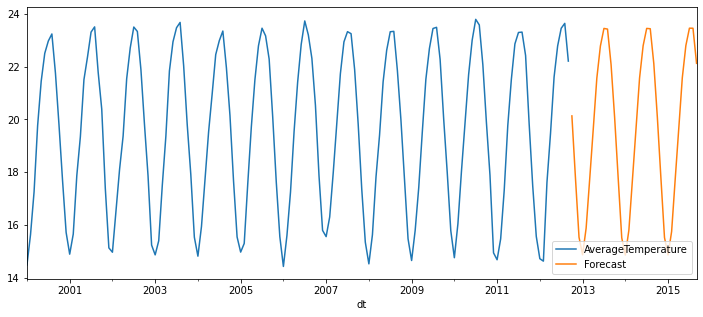

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 

df_selected = pd.read_csv('GlobalLandTemperaturesByCountry.csv', parse_dates = ["dt"], index_col=0)
df_selected = df_selected.dropna()
df_selected = df_selected.loc['1980-01-01':]
df_selected = df_selected.groupby(['dt']).mean()

df_selected = df_selected.drop(['AverageTemperatureUncertainty'], axis=1)


#probar con diferentes valores de order y seasonal_order

model = SARIMAX(train['AverageTemperature'], 
                            order = (1, 1, 1),
                            seasonal_order =(2, 1, 1, 12))

result = model.fit()


forecast = result.predict(start = len(train),
                            end = (len(train) - 1) + 3 * 12,
                            typ = 'levels').rename('Forecast')

train['AverageTemperature'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)

Modelo Prophet

In [ ]:
from prophet import Prophet

Comprobaciones para el modelo Prophet

In [ ]:
df_selected = df[["dt", "AverageTemperature"]]

# comprobando que la columna de tiempo este en formato datetime
print(df_selected.dtypes)

# Comprobando que las columnas se llamen "ds" y "y" respectivamente
df_selected.rename(columns={'dt': 'ds', 'AverageTemperature': 'y'}, inplace=True)
print(df_selected.head())

dt                    datetime64[ns]
AverageTemperature           float64
dtype: object
          ds      y
0 1743-11-01  4.384
1 1743-12-01  4.384
2 1744-01-01  4.384
3 1744-02-01  4.384
4 1744-03-01  4.384


Creando modelo de la clase Prophet

In [ ]:
# 95% de intervalo de incertidumbre
m = Prophet(interval_width = 0.95)


In [ ]:
df_selected = df_selected.loc[df_selected['ds'] < '2010-09-01']
m.fit(df_selected)

21:27:23 - cmdstanpy - INFO - Chain [1] start processing
21:31:27 - cmdstanpy - INFO - Chain [1] done processing


Creando nuevas fechas para las predicciones

In [ ]:
prediction_dates = m.make_future_dataframe(periods=36, freq='MS')
prediction_dates.tail()

,ds
3233,2013-04-01
3234,2013-05-01
3235,2013-06-01
3236,2013-07-01
3237,2013-08-01


Obteniendo columnas de la prediccion

In [ ]:
predict = m.predict(prediction_dates)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3233,2013-04-01,19.523380,-0.300420,38.880688
3234,2013-05-01,21.912689,3.513335,41.217286
3235,2013-06-01,23.481831,5.484175,43.774451
3236,2013-07-01,24.355192,5.058475,43.475955
3237,2013-08-01,24.191647,5.337812,43.515571


Graficando predicciones

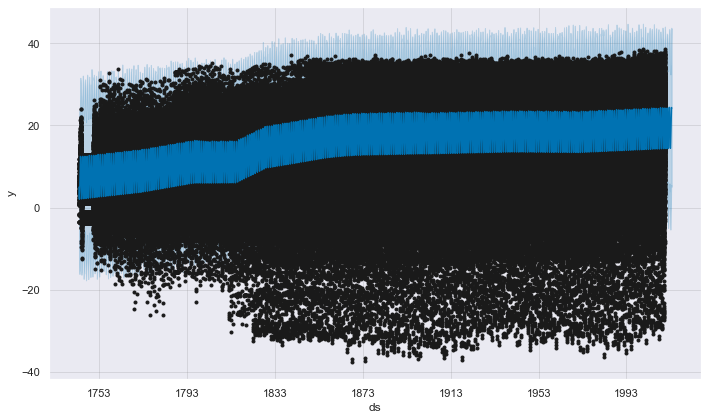

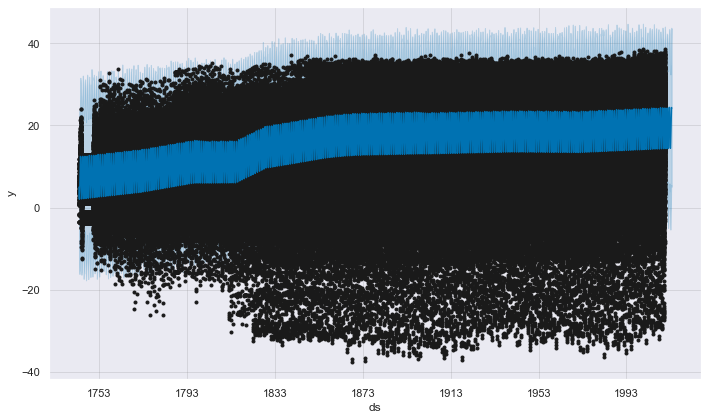

In [ ]:
m.plot(predict, uncertainty=True)

Graficando componentes

Graficando subdataset de las predicciones

,ds,y,type
0,1900-02-01,13.985923,yhat
1,1900-03-01,15.831035,yhat
2,1900-04-01,18.129966,yhat
3,1900-05-01,20.517118,yhat
4,1900-06-01,22.141503,yhat


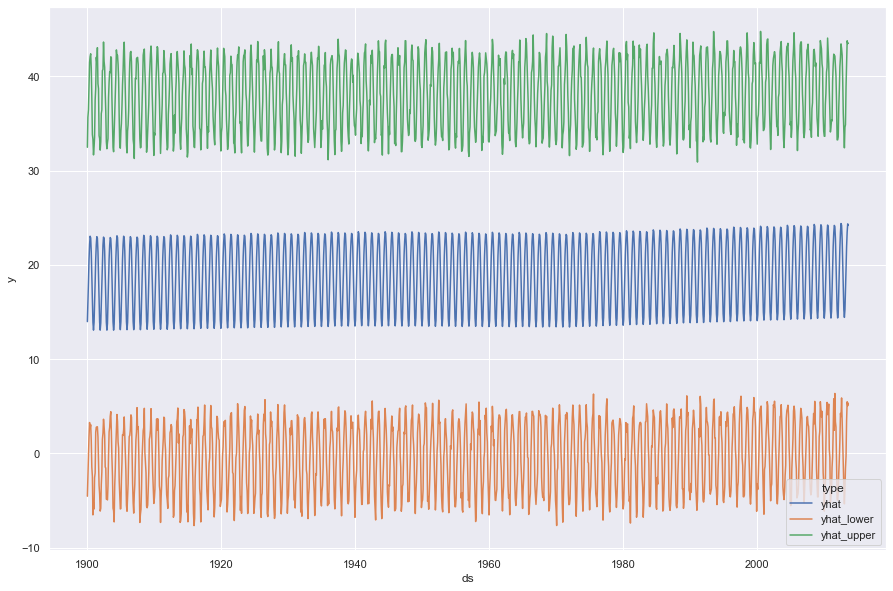

In [ ]:
# seleccionar por un rango de fechas
pd.options.mode.chained_assignment = None  # default='warn'
df_selected = predict.loc[predict['ds'] > '1900-01-01']
# join all columns into one with different types in a new column called 'type'
df_selected_yh = df_selected[['ds', 'yhat']]
df_selected_yh.columns = ['ds', 'y']
df_selected_yh['type'] = 'yhat'
df_selected_yhl = df_selected[['ds', 'yhat_lower']]
df_selected_yhl.columns = ['ds', 'y']
df_selected_yhl['type'] = 'yhat_lower'
df_selected_yhu = df_selected[['ds', 'yhat_upper']]
df_selected_yhu.columns = ['ds', 'y']
df_selected_yhu['type'] = 'yhat_upper'
df_selected = pd.concat([df_selected_yh, df_selected_yhl, df_selected_yhu], ignore_index=True)
# graficar el modelo
sns.lineplot(x='ds', y='y', data=df_selected, hue='type', markers=True)
df_selected.head()

Validacion del modelo

MAPE: 0.02246363951409451


<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

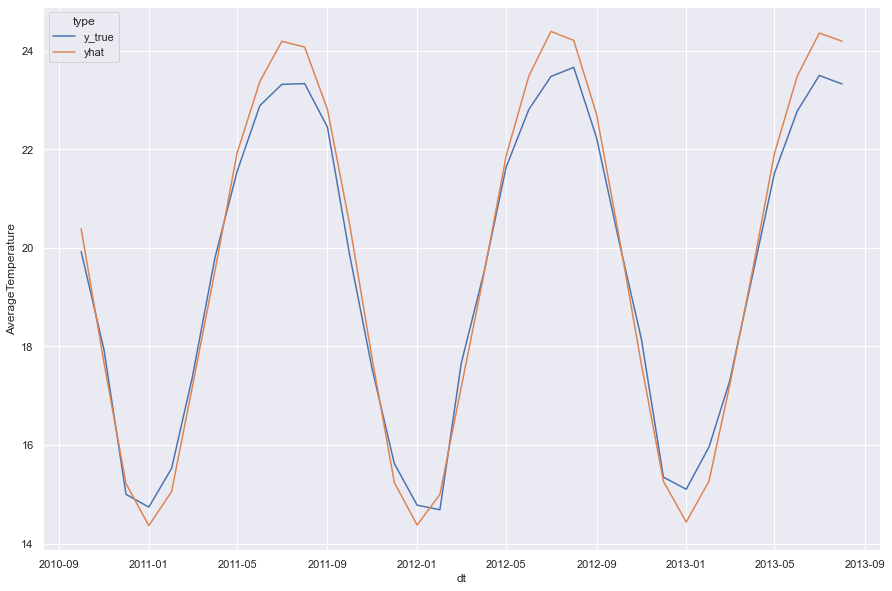

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

y_true = df.loc[df['dt'] > '2010-09-01']
# select columns
y_true = y_true[['dt', 'AverageTemperature']]
# get an avergafe of the AverageTemperature of each same datetime in column dt
y_true = y_true.groupby(['dt']).mean().reset_index()
y_true['type'] = 'y_true'
# select only 35 first rows
y_true = y_true.iloc[:35]

# get only yhat from the prediction
y_pred = df_selected.loc[df_selected['ds'] > '2010-09-01']
y_pred = y_pred[y_pred['type'] == 'yhat']

# rename columns
y_pred.rename(columns={'ds': 'dt', 'y': 'AverageTemperature'}, inplace=True)
mape = mean_absolute_percentage_error(y_true['AverageTemperature'], y_pred['AverageTemperature'])
print(f'MAPE: {mape}')

y_true = pd.concat([y_true, y_pred], ignore_index=True)
sns.lineplot(x='dt', y='AverageTemperature', data=y_true, hue='type', markers=True)


Prophet predict of future 3 years

21:31:40 - cmdstanpy - INFO - Chain [1] start processing
21:35:37 - cmdstanpy - INFO - Chain [1] done processing


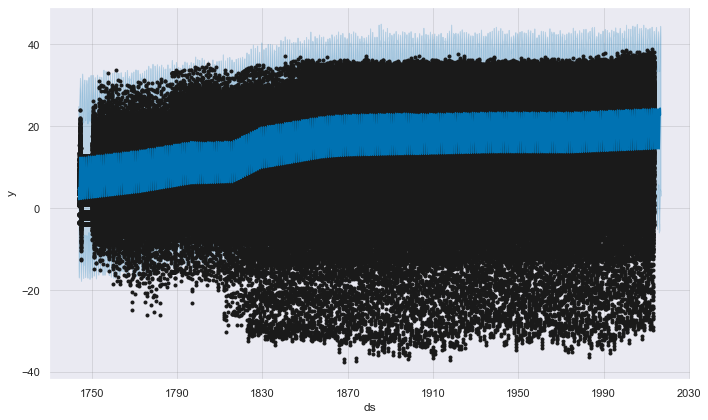

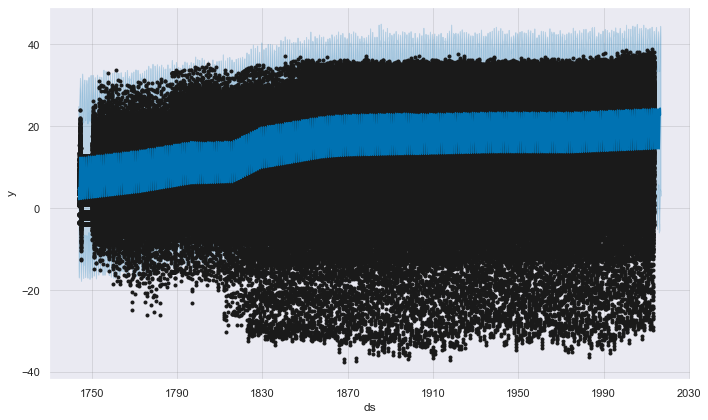

In [ ]:
# 95% de intervalo de incertidumbre
m = Prophet(interval_width = 0.95)
# seleccionando columnas
df_selected = df[["dt", "AverageTemperature"]]
# Comprobando que las columnas se llamen "ds" y "y" respectivamente
df_selected.rename(columns={'dt': 'ds', 'AverageTemperature': 'y'}, inplace=True)
# fit with all data
m.fit(df_selected)
# make future dataframe
prediction_dates = m.make_future_dataframe(periods=36, freq='MS')
prediction_dates.tail()
# predict and get columns
predict = m.predict(prediction_dates)
predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# plot the model
m.plot(predict, uncertainty=True)

,ds,y,type
0,2010-02-01,15.083714,yhat
1,2010-03-01,17.101768,yhat
2,2010-04-01,19.447862,yhat
3,2010-05-01,21.828974,yhat
4,2010-06-01,23.337032,yhat


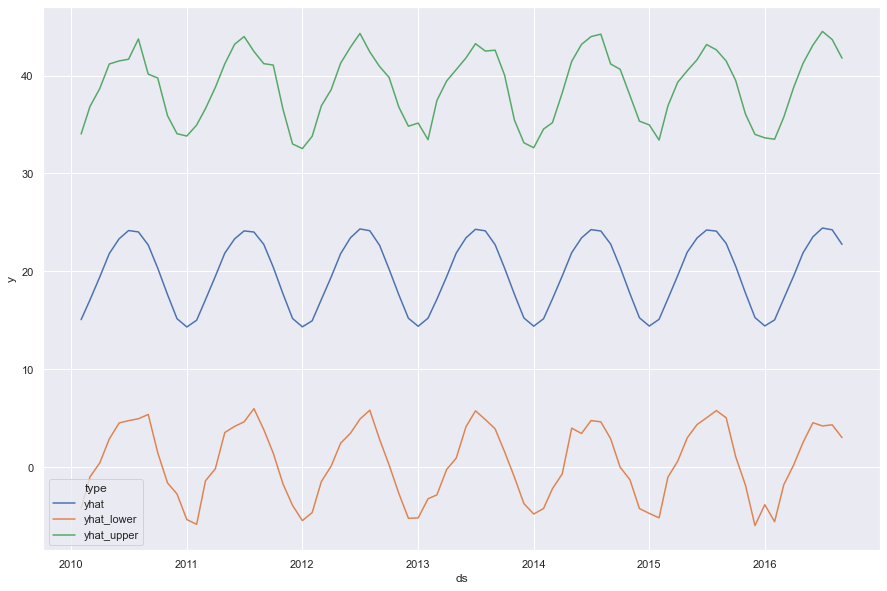

In [ ]:
# seleccionar por un rango de fechas
pd.options.mode.chained_assignment = None  # default='warn'
df_selected = predict.loc[predict['ds'] > '2010-01-01']
# join all columns into one with different types in a new column called 'type'
df_selected_yh = df_selected[['ds', 'yhat']]
df_selected_yh.columns = ['ds', 'y']
df_selected_yh['type'] = 'yhat'
df_selected_yhl = df_selected[['ds', 'yhat_lower']]
df_selected_yhl.columns = ['ds', 'y']
df_selected_yhl['type'] = 'yhat_lower'
df_selected_yhu = df_selected[['ds', 'yhat_upper']]
df_selected_yhu.columns = ['ds', 'y']
df_selected_yhu['type'] = 'yhat_upper'
df_selected = pd.concat([df_selected_yh, df_selected_yhl, df_selected_yhu], ignore_index=True)
# graficar el modelo
sns.lineplot(x='ds', y='y', data=df_selected, hue='type', markers=True)
df_selected.head()